# Content and Objectives

- Show spreading in time and frequency domain
- BPSk symbols are being pulse-shaped by rectangular w. and wo. spreading

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Parameters

In [3]:
# number of realizations along which to average the psd estimate
n_real = 100

# modulation scheme and constellation points
constellation = [ -1, 1 ]

# number of symbols    
n_symb = 100
t_symb = 1.0 

chips_per_symbol = 8
samples_per_chip = 8
samples_per_symbol = samples_per_chip * chips_per_symbol


# parameters for frequency regime
N_fft = 512
omega = np.linspace( -np.pi, np.pi, N_fft )
f_vec = omega / ( 2 * np.pi * t_symb / samples_per_symbol )

# Real data-modulated Tx-signal

In [4]:
# define rectangular function responses    
rect = np.ones( samples_per_symbol )
rect /= np.linalg.norm( rect )


# number of realizations along which to average the psd estimate
n_real = 10


# initialize two-dimensional field for collecting several realizations along which to average 
RECT_PSD = np.zeros( (n_real, N_fft ) ) 
DSSS_PSD = np.zeros( (n_real, N_fft ) )


# get chips and signature

# NOTE: looping until number of +-1 chips in | sum ones - 0.5 N_chips | < 0.2 N_chips,
# i.e., number of +1,-1 is approximately 1/2 (up to 20 percent)
while True:
    dsss_chips = (-1) ** np.random.randint( 0, 2, size = chips_per_symbol )

    if np.abs( np.sum( dsss_chips > 0) - chips_per_symbol/2 ) / chips_per_symbol < .2:
        break

# generate signature out of chips by putting samples_per_symbol samples with chip amplitude  
# normalize signature to energy 1
dsss_signature = np.ones( samples_per_symbol )
for n in range( chips_per_symbol ):
    dsss_signature[ n * samples_per_chip : (n+1) * samples_per_chip ] *= dsss_chips[ n ]  
dsss_signature /= np.linalg.norm( dsss_signature )   
     
    
# activate switch if chips should be resampled for every simulation
# this would average (e.g., for PSD) instead of showing "one reality"
new_chips_per_sim = 1
     
    
# loop for realizations
for k in np.arange( n_real ):

    if new_chips_per_sim:
        
        # resample signature using identical method as above
        while True:
            dsss_chips = (-1) ** np.random.randint( 0, 2, size = chips_per_symbol )
            if np.abs( np.sum( dsss_chips > 0) - chips_per_symbol/2 ) / chips_per_symbol < .2:
                break
                
        # get signature 
        dsss_signature = np.ones( samples_per_symbol )
        for n in range( chips_per_symbol ):
            dsss_signature[ n * samples_per_chip : (n+1) * samples_per_chip ] *= dsss_chips[ n ]
        dsss_signature /= np.linalg.norm( dsss_signature )   
    
    # generate random binary vector and modulate
    data = np.random.randint( 2, size = n_symb )
    mod = [ constellation[ d ] for d in data ]

    # get signals by putting symbols and filtering
    s_up = np.zeros( n_symb * samples_per_symbol )  
    s_up[ :: samples_per_symbol ] = mod

    
    # apply RECTANGULAR and CDMA shaping in time domain
    s_rect = np.convolve( rect, s_up )        
    s_dsss = np.convolve( dsss_signature, s_up )

    
    # get spectrum 
    RECT_PSD[ k, :] = np.abs( np.fft.fftshift( np.fft.fft( s_rect, N_fft ) ) )**2
    DSSS_PSD[ k, :] = np.abs( np.fft.fftshift( np.fft.fft( s_dsss, N_fft ) ) )**2

# average along realizations
RECT_av = np.average( RECT_PSD, axis=0 )
RECT_av /= np.max( RECT_av )

DSSS_av = np.average( DSSS_PSD, axis=0 )
DSSS_av /= np.max( DSSS_av )

Text(0.5,1,'$|S(f)|^2$')

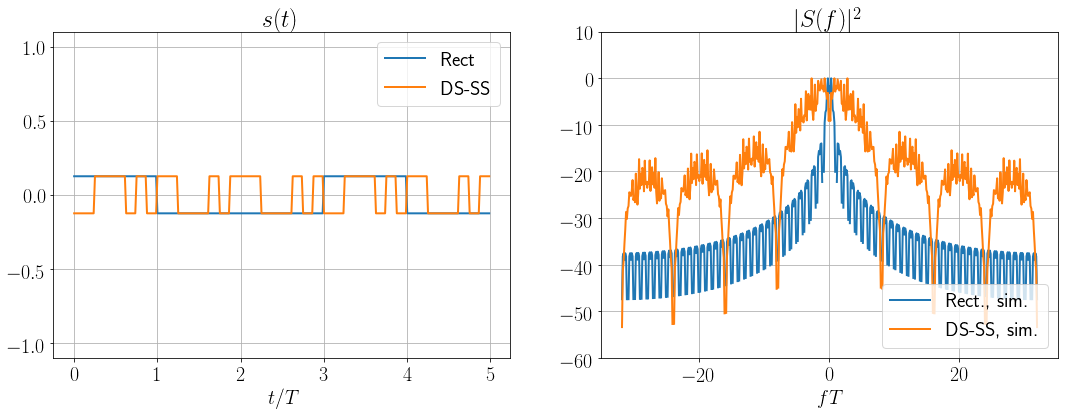

In [5]:
# show limited amount of symbols in time domain
N_syms_plot = 5
t_plot = np.arange( 0, N_syms_plot * t_symb, t_symb / samples_per_symbol )


# plot
plt.figure()

plt.subplot(121)
plt.plot( t_plot, s_rect[ : N_syms_plot * samples_per_symbol], linewidth=2.0, label='Rect')    
plt.plot( t_plot, s_dsss[ : N_syms_plot * samples_per_symbol ], linewidth=2.0, label='DS-SS')    

plt.ylim( (-1.1, 1.1 ) )    
plt.grid( True )
plt.legend(loc='upper right')    
plt.xlabel('$t/T$')
plt.title('$s(t)$')

plt.subplot(122)

np.seterr(divide='ignore') # ignore warning for logarithm of 0
plt.plot( f_vec, 10*np.log10( RECT_av ), linewidth=2.0, label='Rect., sim.' )  
plt.plot( f_vec, 10*np.log10( DSSS_av ), linewidth=2.0, label='DS-SS, sim.' )   
np.seterr(divide='warn') # enable warning for logarithm of 0

plt.grid(True)    
plt.legend(loc='lower right')    
plt.ylim( (-60, 10 ) )

plt.xlabel('$fT$')
plt.title('$|S(f)|^2$')